In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F

import matplotlib.colors as mcolors


# Q1(a)

In [2]:
# Load the MountainCar-v0 environment
env = gym.make('MountainCar-v0')

# Print the state and action space
print("State Space:", env.observation_space)
print("Action Space:", env.action_space)

# Initialize the environment
state = env.reset()
done = False
total_reward = 0
steps = 0

# Random agent loop to understand reward function
while not done:
    action = env.action_space.sample()  # Random action
    next_state, reward, done, info,_ = env.step(action)
    total_reward += reward
    steps += 1
    if steps%10000==0:
        print(f"Step: {steps}")
        print(f"State: {next_state}")
        print(f"Action: {action}")
        print(f"Reward: {reward}")
        print("-" * 30)

print("Total reward:", total_reward)
env.close()


State Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action Space: Discrete(3)
Step: 10000
State: [-0.35644105  0.00581925]
Action: 0
Reward: -1.0
------------------------------
Step: 20000
State: [-1.036639    0.02862402]
Action: 2
Reward: -1.0
------------------------------
Step: 30000
State: [-0.5471804   0.03507504]
Action: 1
Reward: -1.0
------------------------------
Total reward: -34695.0


# Observations
**State Space**: The state space consists of two continuous variables:

Position of the car (ranging from -1.2 to 0.6)
Velocity of the car (ranging from -0.07 to 0.07)
Action Space: The action space is discrete with three possible actions:

0: Push the car left
1: Do nothing
2: Push the car right

**Reward**: For each time step, the agent receives a reward of -1 until it reaches the goal at the top of the mountain on the right (position >= 0.5), at which point the episode terminates. The constant negative reward encourages the agent to reach the goal as quickly as possible to minimize the number of time steps.

**Objective**: The random agent does not learn or optimize behavior, so it typically takes a high number of steps without reaching the goal due to random action selection, highlighting the need for a more intelligent policy for success.

# Q1(b)

In [3]:
# Define model
class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()

        # Define network layers
        self.fc1 = nn.Linear(in_states, h1_nodes)   # first fully connected layer
        self.out = nn.Linear(h1_nodes, out_actions) # ouptut layer w

    def forward(self, x):
        x = F.relu(self.fc1(x)) # Apply rectified linear unit (ReLU) activation
        x = self.out(x)         # Calculate output
        return x

# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)


In [4]:
# Hyperparameters (adjustable)
learning_rate_a = 0.01         # learning rate (alpha)
discount_factor_g = 0.9         # discount rate (gamma)    
network_sync_rate = 50000          # number of steps the agent takes before syncing the policy and target network
replay_memory_size = 100000       # size of replay memory
mini_batch_size = 32            # size of the training data set sampled from the replay memory

num_divisions = 20

In [5]:

# MountainCar Deep Q-Learning
class MountainCarDQL():
    # Neural Network
    loss_fn = nn.MSELoss()          # NN Loss function. MSE=Mean Squared Error can be swapped to something else.
    optimizer = None                # NN Optimizer. Initialize later.

    def __init__(self,learning_rate=0.01,discount_factor_g = 0.9,network_sync_rate = 50000,replay_memory_size=100000,mini_batch_size = 32,num_divisions=20):
         # Initialize placeholders for tracking
        self.total_steps = 0
        self.best_mean_reward = float('-inf')
        self.mean_rewards_per_step = []
        self.best_mean_rewards_per_step = []
        self.mean_window = 1000
        self.render = False

        
        self.learning_rate = learning_rate
        self.discount_factor_g = discount_factor_g          
        self.network_sync_rate = network_sync_rate         
        self.replay_memory_size = replay_memory_size     
        self.mini_batch_size = mini_batch_size           
        self.num_divisions = num_divisions
        
        env = gym.make('MountainCar-v0', render_mode='human' if self.render else None)
        
        # Divide position and velocity into segments
        self.pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)    # Between -1.2 and 0.6
        self.vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)    # Between -0.07 and 0.07

        self.epsilon = 1 # 1 = 100% random actions
         # List to keep track of rewards collected per episode. Initialize list to 0's.
        self.rewards_per_episode = []

        # List to keep track of epsilon decay
        self.epsilon_history = []        

    # Train the environment
    def train(self, episodes, render=False):
        # Create FrozenLake instance
        num_states = env.observation_space.shape[0] # expecting 2: position & velocity
        num_actions = env.action_space.n
        

        memory = ReplayMemory(self.replay_memory_size)

        # Create policy and target network. Number of nodes in the hidden layer can be adjusted.
        policy_dqn = DQN(in_states=num_states, h1_nodes=10, out_actions=num_actions)
        target_dqn = DQN(in_states=num_states, h1_nodes=10, out_actions=num_actions)

        # Make the target and policy networks the same (copy weights/biases from one network to the other)
        target_dqn.load_state_dict(policy_dqn.state_dict())
        
        # Policy network optimizer. "Adam" optimizer can be swapped to something else. 
        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate)

       

        # Track number of steps taken. Used for syncing policy => target network.
        step_count=0
        goal_reached=False
        best_rewards=-200
            
        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal

            rewards = 0

            # Agent navigates map until it falls into hole/reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and rewards>-1000):

                # Select action based on epsilon-greedy
                if random.random() < self.epsilon:
                    # select random action
                    action = env.action_space.sample() # actions: 0=left,1=idle,2=right
                else:
                    # select best action            
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state)).argmax().item()

                # Execute action
                new_state,reward,terminated,truncated,_ = env.step(action)

                # Accumulate reward
                rewards += reward

                # Save experience into memory
                memory.append((state, action, new_state, reward, terminated)) 

                # Move to the next state
                state = new_state

                # Increment step counter
                step_count+=1
                self.total_steps += 1

            # Keep track of the rewards collected per episode.
            self.rewards_per_episode.append(rewards)
            if(terminated):
                goal_reached = True

            # Graph training progress
            if(i!=0 and i%1000==0):
                mean_reward = np.mean(self.rewards_per_episode[-5000:])
                self.mean_rewards_per_step.append((self.total_steps, np.round(mean_reward,2)))
                
                self.best_mean_reward = max(self.best_mean_reward, np.round(mean_reward,2))
                self.best_mean_rewards_per_step.append((self.total_steps, self.best_mean_reward))

                print(f'Epoch:{max(1,i-1000+1)}-{i} Epsilon:{np.round(self.epsilon,2)} Best Reward:{max(self.rewards_per_episode)} Mean Reward:{np.round(mean_reward,2)} Best Mean Reward:{np.round(self.best_mean_reward,2)}')     
                self.plot_progress()
            
            if rewards>best_rewards:
                best_rewards = rewards
                print(f'Best rewards so far: {best_rewards}')
                # Save policy
                torch.save(policy_dqn.state_dict(), f"mountaincar_dql_{i}.pt")
                print(f"Best model saved as mountaincar_dql_{i}.pt")

            # Check if senough experience has been collected
            if len(memory)>self.mini_batch_size and goal_reached:
                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)        

                # Decay epsilon
                self.epsilon = max(self.epsilon - 1/episodes, 0)
                self.epsilon_history.append(self.epsilon)

                # Copy policy network to target network after a certain number of steps
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count=0                    

        # Close environment
        env.close()
        
    def plot_progress(self):
        # Extract the total_steps and rewards from tracked mean and best mean rewards
        steps, mean_rewards = zip(*self.mean_rewards_per_step)
        steps_best, best_mean_rewards = zip(*self.best_mean_rewards_per_step)
        # import pdb;pdb.set_trace()
    
        plt.figure(figsize=(10, 6))
    
        # Plot mean rewards over time with thicker lines and add markers
        plt.plot(steps, mean_rewards, color='blue', linestyle='-', linewidth=1.5, label='Mean Reward over 1000 Episodes', marker='o')
    
        # Plot best mean rewards over time with thicker lines and different color
        plt.plot(steps_best, best_mean_rewards, color='orange', linestyle='-', linewidth=2, label='Best Mean Reward', marker='o')
    
        # # Set axis limits for a similar view
        # plt.ylim(100, max(best_mean_rewards) + 20)
        
        # Add grid for better readability
        plt.grid(True)
    
        # Add labels, title, and legend
        plt.xlabel("Timesteps (Scaled)")
        plt.ylabel("Reward")
        plt.title("DQN Training Performance")
        plt.legend(loc="upper left")
    
        # Save and show the plot
        plt.savefig(f'mean_and_best_mean_rewards_lr_{self.learning_rate}.png')
        # plt.show()
        plt.close()  # Close the figure

   

    def plot_action_choices(self, model_filepath):
        # Load the trained policy network
        policy_dqn = DQN(in_states=2, h1_nodes=10, out_actions=3)  # Adjust according to your DQN setup
        policy_dqn.load_state_dict(torch.load(model_filepath))
        policy_dqn.eval()  # Switch to evaluation mode

        # Define position and velocity ranges based on environment's observation space
        position_range = np.linspace(-1.2, 0.6, 100)  # Positions between -1.2 and 0.6
        velocity_range = np.linspace(-0.07, 0.07, 100)  # Velocities between -0.07 and 0.07

        # Create a mesh grid for position and velocity
        pos_grid, vel_grid = np.meshgrid(position_range, velocity_range)
        action_grid = np.zeros(pos_grid.shape, dtype=int)

        # For each (position, velocity) pair, get the action chosen by the policy
        for i in range(pos_grid.shape[0]):
            for j in range(pos_grid.shape[1]):
                # Convert position and velocity to state tensor
                pos, vel = pos_grid[i, j], vel_grid[i, j]
                state_tensor = self.state_to_dqn_input((pos, vel)).unsqueeze(0)  # Add batch dimension

                # Predict action
                with torch.no_grad():
                    action = policy_dqn(state_tensor).argmax().item()
                action_grid[i, j] = action

        # Define a custom colormap
        cmap = mcolors.ListedColormap(['blue', 'green', 'red'])
        bounds = [-0.5, 0.5, 1.5, 2.5]  # Boundaries for the actions
        norm = mcolors.BoundaryNorm(bounds, cmap.N)

        # Plot the action choices on a 2D grid with custom colormap
        plt.figure(figsize=(10, 6))
        contour = plt.contourf(pos_grid, vel_grid, action_grid, levels=bounds, cmap=cmap, norm=norm, alpha=0.6)
        
        # Create a color legend based on actions
        action_labels = ['Accelerate Left (0)', 'Do Nothing (1)', 'Accelerate Right (2)']
        
        # Add custom legend
        for i, label in enumerate(action_labels):
            plt.scatter([], [], color=cmap(i), label=label)  # Dummy scatter for legend

        plt.colorbar(contour, ticks=[0, 1, 2], label='Action')
        plt.xlabel('Position')
        plt.ylabel('Velocity')
        plt.title('Action Choices of the Trained Agent for Various Position and Velocity Values')
        plt.legend(title="Actions")
        plt.show()
        
    # Optimize policy network
    def optimize(self, mini_batch, policy_dqn, target_dqn):

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:
            if terminated: 
                # Agent receive reward of 0 for reaching goal.
                # When in a terminated state, target q value should be set to the reward.
                target = torch.FloatTensor([reward])
            else:
                # Calculate target q value 
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state)).max()
                    )

            # Get the current set of Q values
            current_q = policy_dqn(self.state_to_dqn_input(state))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_dqn(self.state_to_dqn_input(state)) 
            # Adjust the specific action to the target that was just calculated
            target_q[action] = target
            target_q_list.append(target_q)
                
        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    '''
    Converts a state (position, velocity) to tensor representation.
    Example:
    Input = (0.3, -0.03)
    Return = tensor([16, 6])
    '''
    def state_to_dqn_input(self, state)->torch.Tensor:
        state_p = np.digitize(state[0], self.pos_space)
        state_v = np.digitize(state[1], self.vel_space)
        
        return torch.FloatTensor([state_p, state_v])
    
    # Run the environment with the learned policy
    def test(self, episodes, model_filepath):
        # Create FrozenLake instance
        env = gym.make('MountainCar-v0', render_mode='human')
        num_states = env.observation_space.shape[0]
        num_actions = env.action_space.n

        self.pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)    # Between -1.2 and 0.6
        self.vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)    # Between -0.07 and 0.07

        # Load learned policy
        policy_dqn = DQN(in_states=num_states, h1_nodes=10, out_actions=num_actions) 
        policy_dqn.load_state_dict(torch.load(model_filepath))
        policy_dqn.eval()    # switch model to evaluation mode

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions            

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):  
                # Select best action   
                with torch.no_grad():
                    action = policy_dqn(self.state_to_dqn_input(state)).argmax().item()

                # Execute action
                state,reward,terminated,truncated,_ = env.step(action)

        env.close()

if __name__ == '__main__':
    mountaincar = MountainCarDQL()
    mountaincar.train(50000, False)
    

Epoch:1-1000 Epsilon:1 Best Reward:-1000.0 Mean Reward:-1000.0 Best Mean Reward:-1000.0
Epoch:1001-2000 Epsilon:1 Best Reward:-1000.0 Mean Reward:-1000.0 Best Mean Reward:-1000.0
Epoch:2001-3000 Epsilon:1 Best Reward:-1000.0 Mean Reward:-1000.0 Best Mean Reward:-1000.0
Epoch:3001-4000 Epsilon:1 Best Reward:-1000.0 Mean Reward:-1000.0 Best Mean Reward:-1000.0
Epoch:4001-5000 Epsilon:0.99 Best Reward:-685.0 Mean Reward:-999.93 Best Mean Reward:-999.93
Epoch:5001-6000 Epsilon:0.97 Best Reward:-685.0 Mean Reward:-999.93 Best Mean Reward:-999.93
Epoch:6001-7000 Epsilon:0.95 Best Reward:-685.0 Mean Reward:-999.84 Best Mean Reward:-999.84
Epoch:7001-8000 Epsilon:0.93 Best Reward:-685.0 Mean Reward:-999.83 Best Mean Reward:-999.83
Epoch:8001-9000 Epsilon:0.91 Best Reward:-685.0 Mean Reward:-999.57 Best Mean Reward:-999.57
Epoch:9001-10000 Epsilon:0.89 Best Reward:-594.0 Mean Reward:-999.55 Best Mean Reward:-999.55
Epoch:10001-11000 Epsilon:0.87 Best Reward:-594.0 Mean Reward:-999.16 Best Mean 

/var/folders/fs/1_sgn68n2914x1m2zltpc2m80000gn/T/ipykernel_44994/2266303609.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_dqn.load_state_dict(torch.load(model

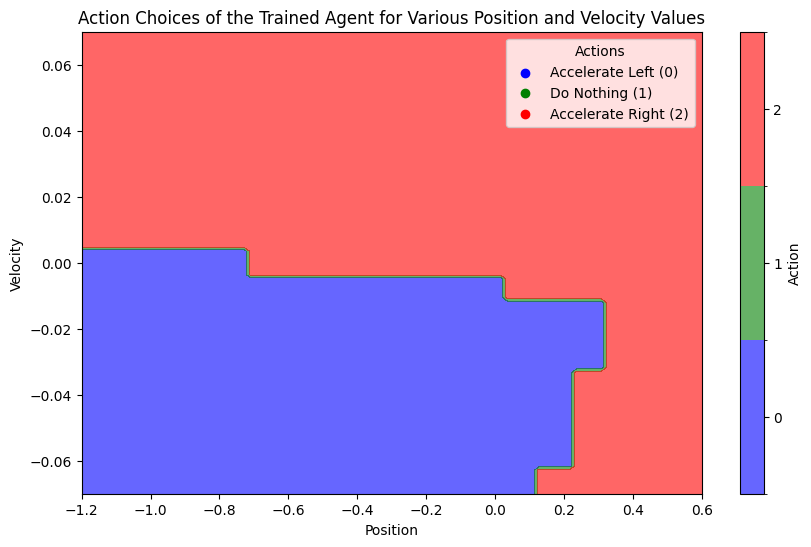

In [6]:
mountaincar.plot_action_choices('mountaincar_dql_45243.pt')

# Observations 
With the most optimized model trained we get the above graph showing us 
1. For Positions>0 The most probable action taken is accelerate right
2. For Position<0 primarily with higher negative values the car is expected to accelerate left

# Q1(c)

In [7]:
if __name__ == '__main__':
    learning_rates_list = [0.1,0.01,0.001]
    for learning_rate in learning_rates_list:
        print(f"Generating Results for Learning Rate {learning_rate}")
        mountaincar = MountainCarDQL(learning_rate=learning_rate)
        mountaincar.train(50000, False)
    

Generating Results for Learning Rate 0.1
Epoch:1-1000 Epsilon:1.0 Best Reward:-473.0 Mean Reward:-999.44 Best Mean Reward:-999.44
Epoch:1001-2000 Epsilon:0.98 Best Reward:-473.0 Mean Reward:-999.7 Best Mean Reward:-999.44
Epoch:2001-3000 Epsilon:0.96 Best Reward:-473.0 Mean Reward:-999.8 Best Mean Reward:-999.44
Epoch:3001-4000 Epsilon:0.94 Best Reward:-473.0 Mean Reward:-999.85 Best Mean Reward:-999.44
Epoch:4001-5000 Epsilon:0.92 Best Reward:-473.0 Mean Reward:-999.86 Best Mean Reward:-999.44
Epoch:5001-6000 Epsilon:0.9 Best Reward:-473.0 Mean Reward:-999.93 Best Mean Reward:-999.44
Epoch:6001-7000 Epsilon:0.88 Best Reward:-473.0 Mean Reward:-999.92 Best Mean Reward:-999.44
Epoch:7001-8000 Epsilon:0.86 Best Reward:-473.0 Mean Reward:-999.92 Best Mean Reward:-999.44
Epoch:8001-9000 Epsilon:0.84 Best Reward:-473.0 Mean Reward:-999.8 Best Mean Reward:-999.44
Epoch:9001-10000 Epsilon:0.82 Best Reward:-473.0 Mean Reward:-999.67 Best Mean Reward:-999.44
Epoch:10001-11000 Epsilon:0.8 Best R